In [ ]:
from google.colab import drive
import os 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import tensorflow as tf 
import tensorflow.keras as tfk 
import tensorflow.keras.layers as tfkl 
plt.rc('font', size=16) 
import random
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging
from sklearn import preprocessing 


tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [ ]:
# Random seed for reproducibility
seed = 89
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
drive.mount('/gdrive')
os.chdir(r'/gdrive/MyDrive/annHomework2/')
x_train = np.load(r'x_train.npy')
y_train = np.load(r'y_train.npy')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
x_train.shape, y_train.shape 

((2429, 36, 6), (2429,))

Is it already divided into windows? I would say yes. 

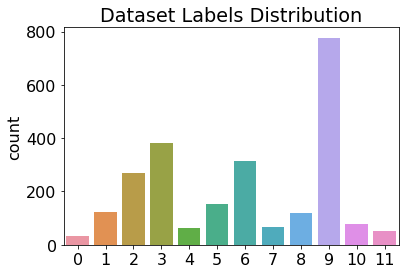

In [ ]:
# plot labels distribution 
sns.countplot( x = y_train) 
plt.title('Dataset Labels Distribution')
plt.show()

As we can see dataset is pretty unbalanced. But, looking at early subs, more prominent classes do not seem to be the best predicted. Why? 

In [ ]:
# preprocess  
y_train = tfk.utils.to_categorical(y_train) 

In [ ]:
train_data = np.concatenate([x for x in x_train]) 
scaler = preprocessing.StandardScaler().fit(train_data)

x_train_trans = [] 
for el in x_train: 
  x_train_trans.append(scaler.transform(el))
del x_train 
# all set

x_train = np.asarray(x_train_trans) 

In [ ]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_train, y_train, test_size=0.2, random_state=seed)

In [ ]:
# check 
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape) 
x_train[0][1]
y_train[0]

(1943, 36, 6) (1943, 12) (486, 36, 6) (486, 12)


array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

# **LSTM + QUASI-SVM**

In [ ]:
input_shape = (36,6)

In [ ]:
def build_LSTM_classifier(input_shape, classes=12):
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    lstm = tfkl.LSTM(256, return_sequences=True, kernel_initializer="he_uniform")(input_layer) 
    lstm = tfkl.LSTM(256, return_sequences=True, kernel_initializer="he_uniform")(lstm)  
    lstm = tfkl.LSTM(256, return_sequences=True, kernel_initializer="he_uniform")(lstm)  
    lstm = tfkl.LSTM(256, return_sequences=True, kernel_initializer="he_uniform")(lstm)  
    lstm = tfkl.LSTM(256)(lstm)
    
    classifier = tfk.Sequential([ 
        tfkl.Input(shape=(256,)), 
        tfkl.experimental.RandomFourierFeatures(output_dim=1024, trainable=True, kernel_initializer="gaussian"),
        tfkl.Dense(units=128,  activation='relu', kernel_initializer=tfk.initializers.HeUniform(seed),name='dense_classifier',
                  )]) (lstm)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate = 1e-3), metrics='accuracy')
    return model

In [ ]:
model = build_LSTM_classifier(input_shape = input_shape, classes=12)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 lstm_56 (LSTM)              (None, 36, 256)           269312    
                                                                 
 lstm_57 (LSTM)              (None, 36, 256)           525312    
                                                                 
 lstm_58 (LSTM)              (None, 36, 256)           525312    
                                                                 
 lstm_59 (LSTM)              (None, 36, 256)           525312    
                                                                 
 lstm_60 (LSTM)              (None, 256)               525312    
                                                                 
 sequential_14 (Sequential)  (None, 128)               394369

In [ ]:
# Train the model
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 128,
    epochs = 100,
    validation_data = (x_test, y_test) ,      
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/100
16/16 [==============================] - 9s 187ms/step - loss: 2.1173 - accuracy: 0.3052 - val_loss: 2.0085 - val_accuracy: 0.2572 - lr: 0.0010
Epoch 2/100
16/16 [==============================] - 1s 38ms/step - loss: 1.7569 - accuracy: 0.4117 - val_loss: 1.6835 - val_accuracy: 0.4239 - lr: 0.0010
Epoch 3/100
16/16 [==============================] - 1s 36ms/step - loss: 1.6259 - accuracy: 0.4581 - val_loss: 1.6766 - val_accuracy: 0.4465 - lr: 0.0010
Epoch 4/100
16/16 [==============================] - 1s 35ms/step - loss: 1.5482 - accuracy: 0.4658 - val_loss: 1.4844 - val_accuracy: 0.4794 - lr: 0.0010
Epoch 5/100
16/16 [==============================] - 1s 36ms/step - loss: 1.3932 - accuracy: 0.5234 - val_loss: 1.4063 - val_accuracy: 0.5185 - lr: 0.0010
Epoch 6/100
16/16 [==============================] - 1s 35ms/step - loss: 1.3491 - accuracy: 0.5409 - val_loss: 1.3418 - val_accuracy: 0.5185 - lr: 0.0010
Epoch 7/100
16/16 [==============================] - 1s 36ms/step - l

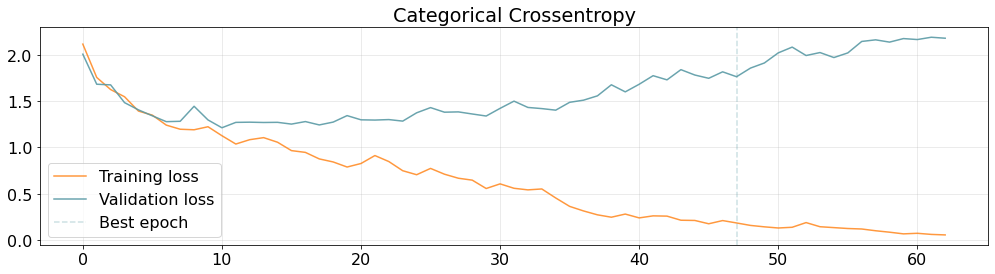

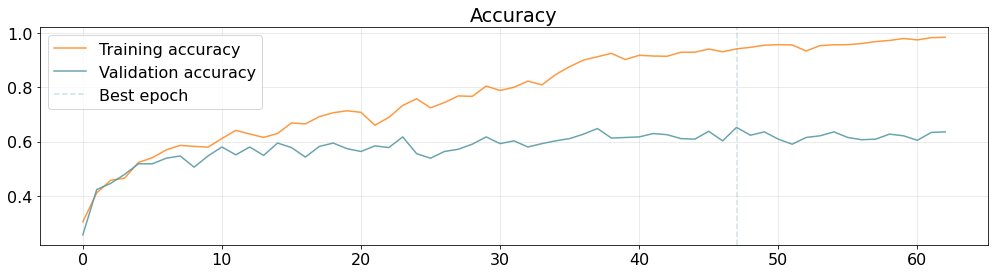

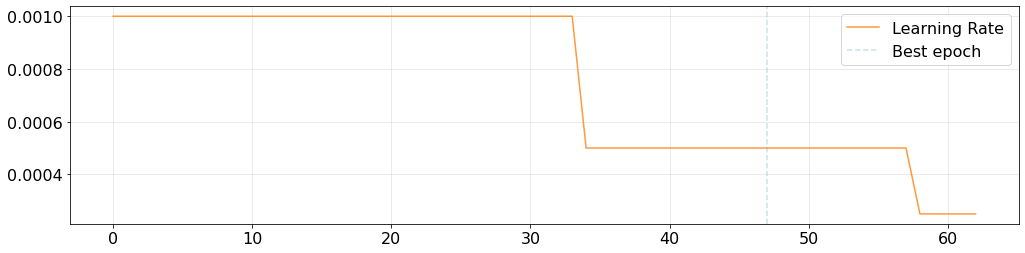

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

16/16 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
{'loss': 0.0, 'accuracy': 0.0}
16/16 [==============================] - 2s 11ms/step
Accuracy: 0.6523
Precision: 0.6033
Recall: 0.5765
F1: 0.5781
F1 (per class): [0.47058824 0.60869565 0.88073394 0.44303797 0.22222222 0.31428571
 0.74796748 0.31578947 0.9        0.73684211 0.89655172 0.4       ]


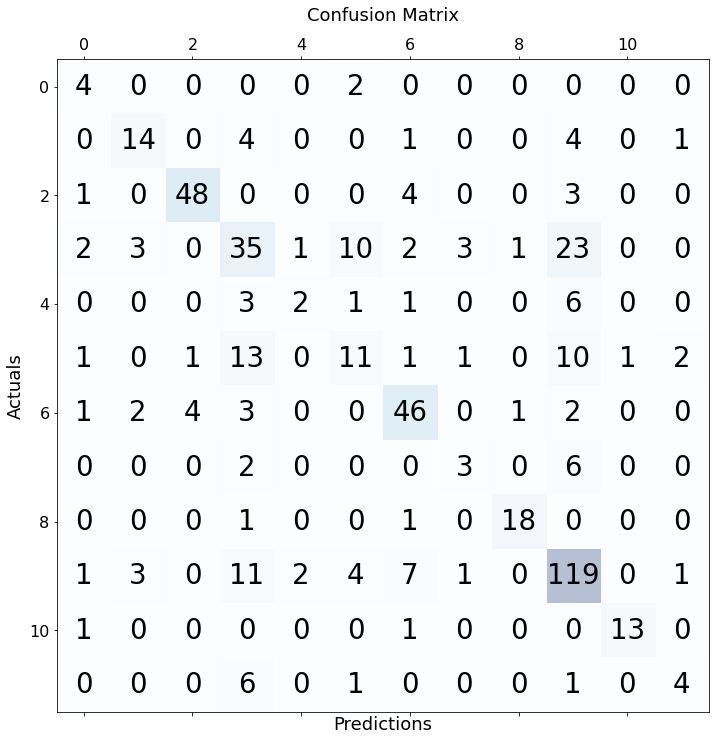

In [ ]:
metrics = model.evaluate(x_test, return_dict=True)
print(metrics)

labels = y_test 
predictions = model.predict(x_test) 
assert len(labels) == len(predictions)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1_classes = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average=None)

print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))
print('F1 (per class):' ,f1_classes)

# Plot the confusion matrix
ig, ax = plt.subplots(figsize=(12,12))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

        
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()